### Inception v1
Inception v1网络是一个精心设计的22层卷积网络，并提出了具有良好局部特征结构的Inception模块，即对特征并行地执行多个大小不同的卷积运算与池化，最后再拼接到一起。由于1×1、3×3和5×5的卷积运算对应不同的特征图区域，因此这样做的好处是可以得到更好的图像表征信息。

Inception模块如图所示，使用了三个不同大小的卷积核进行卷积运算，同时还有一个最大值池化，然后将这4部分级联起来（通道拼接），送入下一层。

Inception v1网络一共有9个上述堆叠的模块，共有22层，在最后的Inception模块处使用了全局平均池化。为了避免深层网络训练时带来的梯度消失问题，作者还引入了两个辅助的分类器，在第3个与第6个Inception模块输出后执行Softmax并计算损失，在训练时和最后的损失一并回传。

**Inception v1的参数量是AlexNet的1/12, VGGNet的1/3，适合处理大规模数据，尤其是对于计算资源有限的平台。**

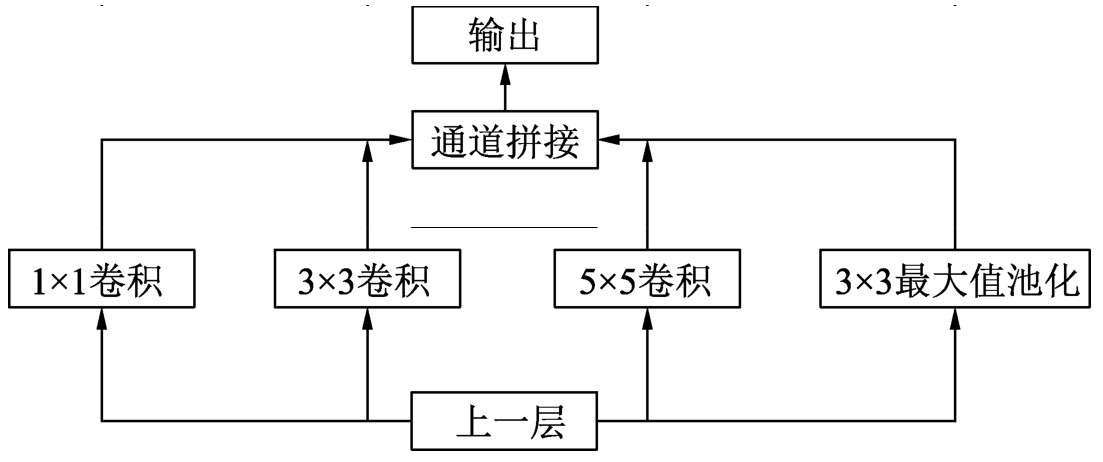

### Inception v1改进型
在上述模块的基础上，为进一步降低网络参数量，Inception又增加了多个1×1的卷积模块。如图所示，这种1×1的模块可以先将特征图降维，再送给3×3和5×5大小的卷积核，由于通道数的降低，参数量也有了较大的减少。**值得一提的是，用1×1卷积核实现降维的思想，在后面的多个轻量化网络中都会使用到。**

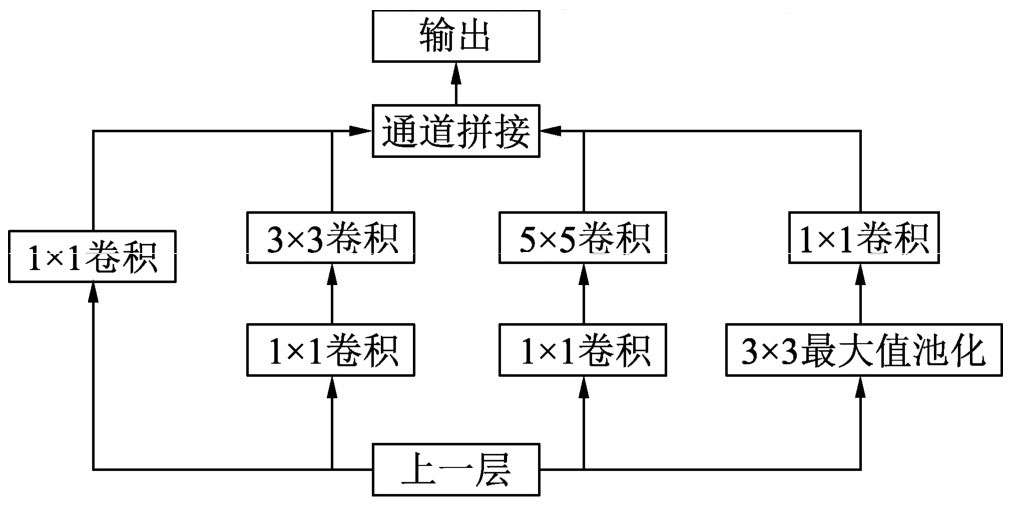

In [1]:
import torch
from inceptionv1 import Inceptionv1

In [2]:
#网格实例化，输入模块通道数，并转移到GPU上
net_inceptionv1 = Inceptionv1(3, 64, 32, 64, 64,96, 32).cuda()
net_inceptionv1

#第1个分支，使用1×1卷积，输出通道数为64
#第2个分支，使用1×1卷积与3×3卷积，输出通道数为64
#第3个分支，使用1×1卷积与5×5卷积，输出通道数为96
#第4个分支，使用最大值池化与1×1卷积，输出通道数为32

Inceptionv1(
  (branch1x1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (branch3x3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (branch5x5): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (branch_pool): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

In [3]:
input = torch.randn(1, 3, 256, 256).cuda()
input.shape

torch.Size([1, 3, 256, 256])

In [4]:
output = net_inceptionv1(input)
#可以看到输出的通道数是输入通道数的和，即256=64+64+96+32
output.shape

torch.Size([1, 256, 256, 256])

### Inception v2
在Inception v1网络的基础上，随后又出现了多个Inception版本。Inception v2进一步通过卷积分解与正则化实现更高效的计算，增加了BN层，同时利用两个级联的3×3卷积取代了Inception v1版本中的5×5卷积，如图所示，这种方式既减少了卷积参数量，也增加了网络的非线性能力。

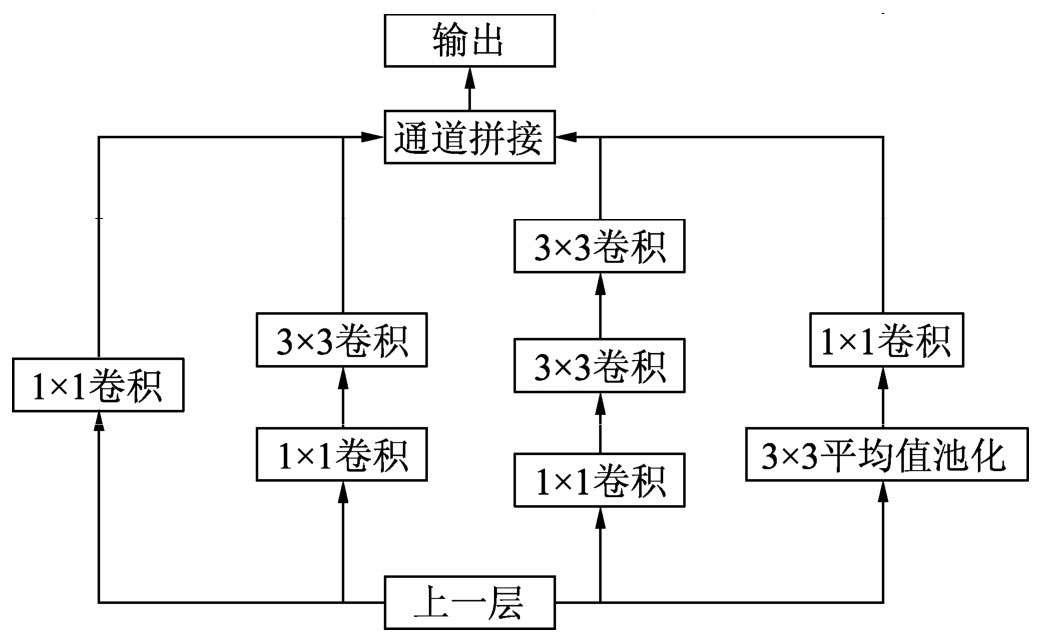

In [5]:
import torch
from inceptionv2 import Inceptionv2

In [6]:
net_inceptionv2 = Inceptionv2().cuda()
net_inceptionv2

#第1个分支，使用1×1卷积，输出通道为96
#第2个分支，使用1×1卷积与3×3卷积，输出通道为64
#第3个分支，使用1×1卷积与两个连续的3×3卷积，输出通道为96
#第4个分支，使用平均池化与1×1卷积，输出通道为64

Inceptionv2(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_runnin

In [7]:
input = torch.randn(1, 192, 32, 32).cuda()
input.shape

torch.Size([1, 192, 32, 32])

In [8]:
output = net_inceptionv2(input)
#输出特征图的通道数为：96+64+96+64=320
output.shape

torch.Size([1, 320, 32, 32])

### Inception v2改进型
更进一步，Inception v2将n×n的卷积运算分解为1×n与n×1两个卷积，如图所示，这种分解的方式可以使计算成本降低33%。

此外，Inception v2还将模块中的卷积核变得更宽而不是更深，形成第三个模块，以解决表征能力瓶颈的问题。Inception v2网络正是由上述的三种不同类型的模块组成的，其计算也更加高效。

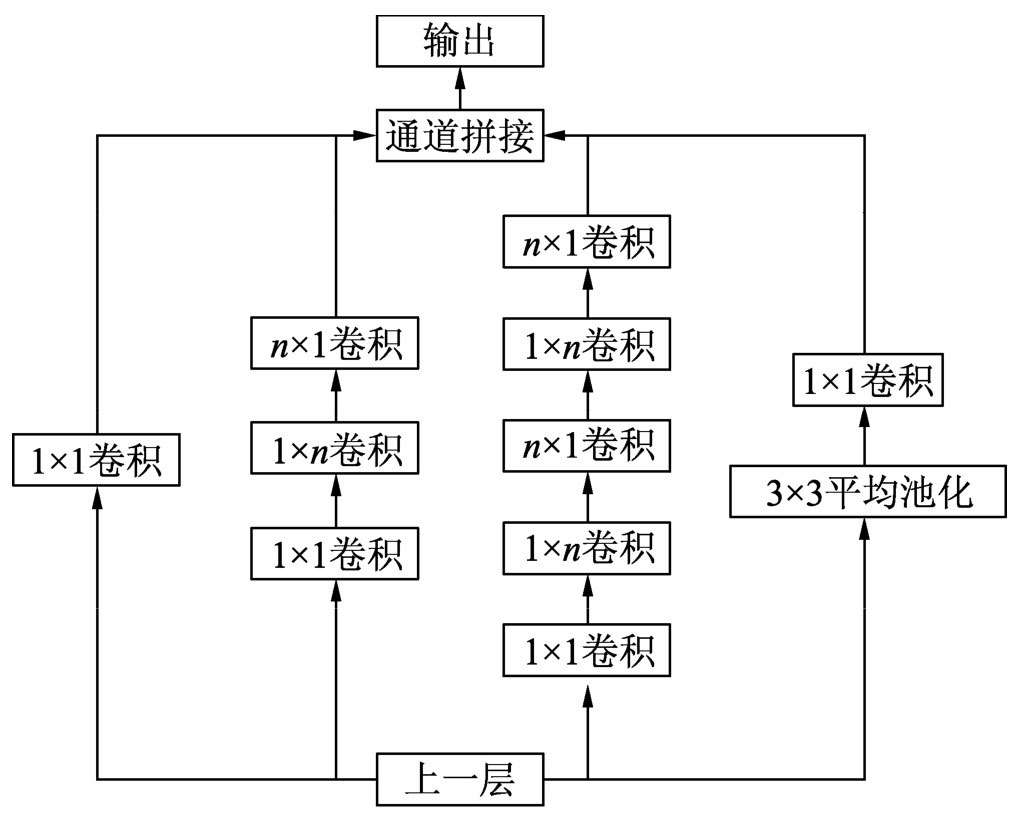

### Inception v3
Inception v3在Inception v2的基础上，使用了RMSProp优化器，在辅助的分类器部分增加了7×7的卷积，并且使用了标签平滑技术。

### Inception v4
Inception v4则是将Inception的思想与残差网络进行了结合，显著提升了训练速度与模型准确率，这里对于模块细节不再展开讲述。至于残差网络这一里程碑式的结构，正是由下一节的网络ResNet引出的。